In [18]:
import obspy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import spectrogram
from scipy.fft import fft, fftfreq, ifft
import datetime
import numpy as np
import glob
import pyasdf
import h5py
import pickle
import wave
from pydub import AudioSegment

In [21]:
#read data
file = "/media/Data/Data/XC/MSEED/noIR/PIG4/HHZ/2012-05-09.PIG4.HHZ.noIR.MSEED"
st_raw = obspy.read(file)

# resample
fs = 21
st_raw.resample(fs)

# make copies
st_broad = st_raw.copy()
st_low = st_raw.copy()
st_high = st_raw.copy()

# filter to a few bands
low_cut = 0.001
high_cut = 10
st_broad.filter("bandpass", freqmin=low_cut, freqmax=10)
st_low.filter("bandpass", freqmin=low_cut, freqmax=1)
st_high.filter("bandpass",freqmin=1,freqmax=10)

1 Trace(s) in Stream:
XC.PIG4..HHZ | 2012-05-09T00:00:00.000000Z - 2012-05-09T23:59:59.952381Z | 21.0 Hz, 1814400 samples

In [ ]:
# trim to times of interest
starttime = obspy.UTCDateTime(2012,5,9,3)
endtime = obspy.UTCDateTime(2012,5,9,5)
st_broad.trim(starttime=starttime,endtime=endtime)
st_low.trim(starttime=starttime,endtime=endtime)
st_high.trim(starttime=starttime,endtime=endtime)

# make a plot
fig,ax = plt.subplots(2,1,figsize=(25,10))
times = [t.datetime for t in st_broad[0].times(type="utcdatetime")]
ax[0].plot(times,st_high[0].data)
ax[1].plot(times,st_low[0].data)
plt.gcf().autofmt_xdate()
plt.show()

# write out audio file
st_broad.write('../outputs/audio/day_test.wav', format='WAV', framerate=70000, rescale=True, width=2)

/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  Th

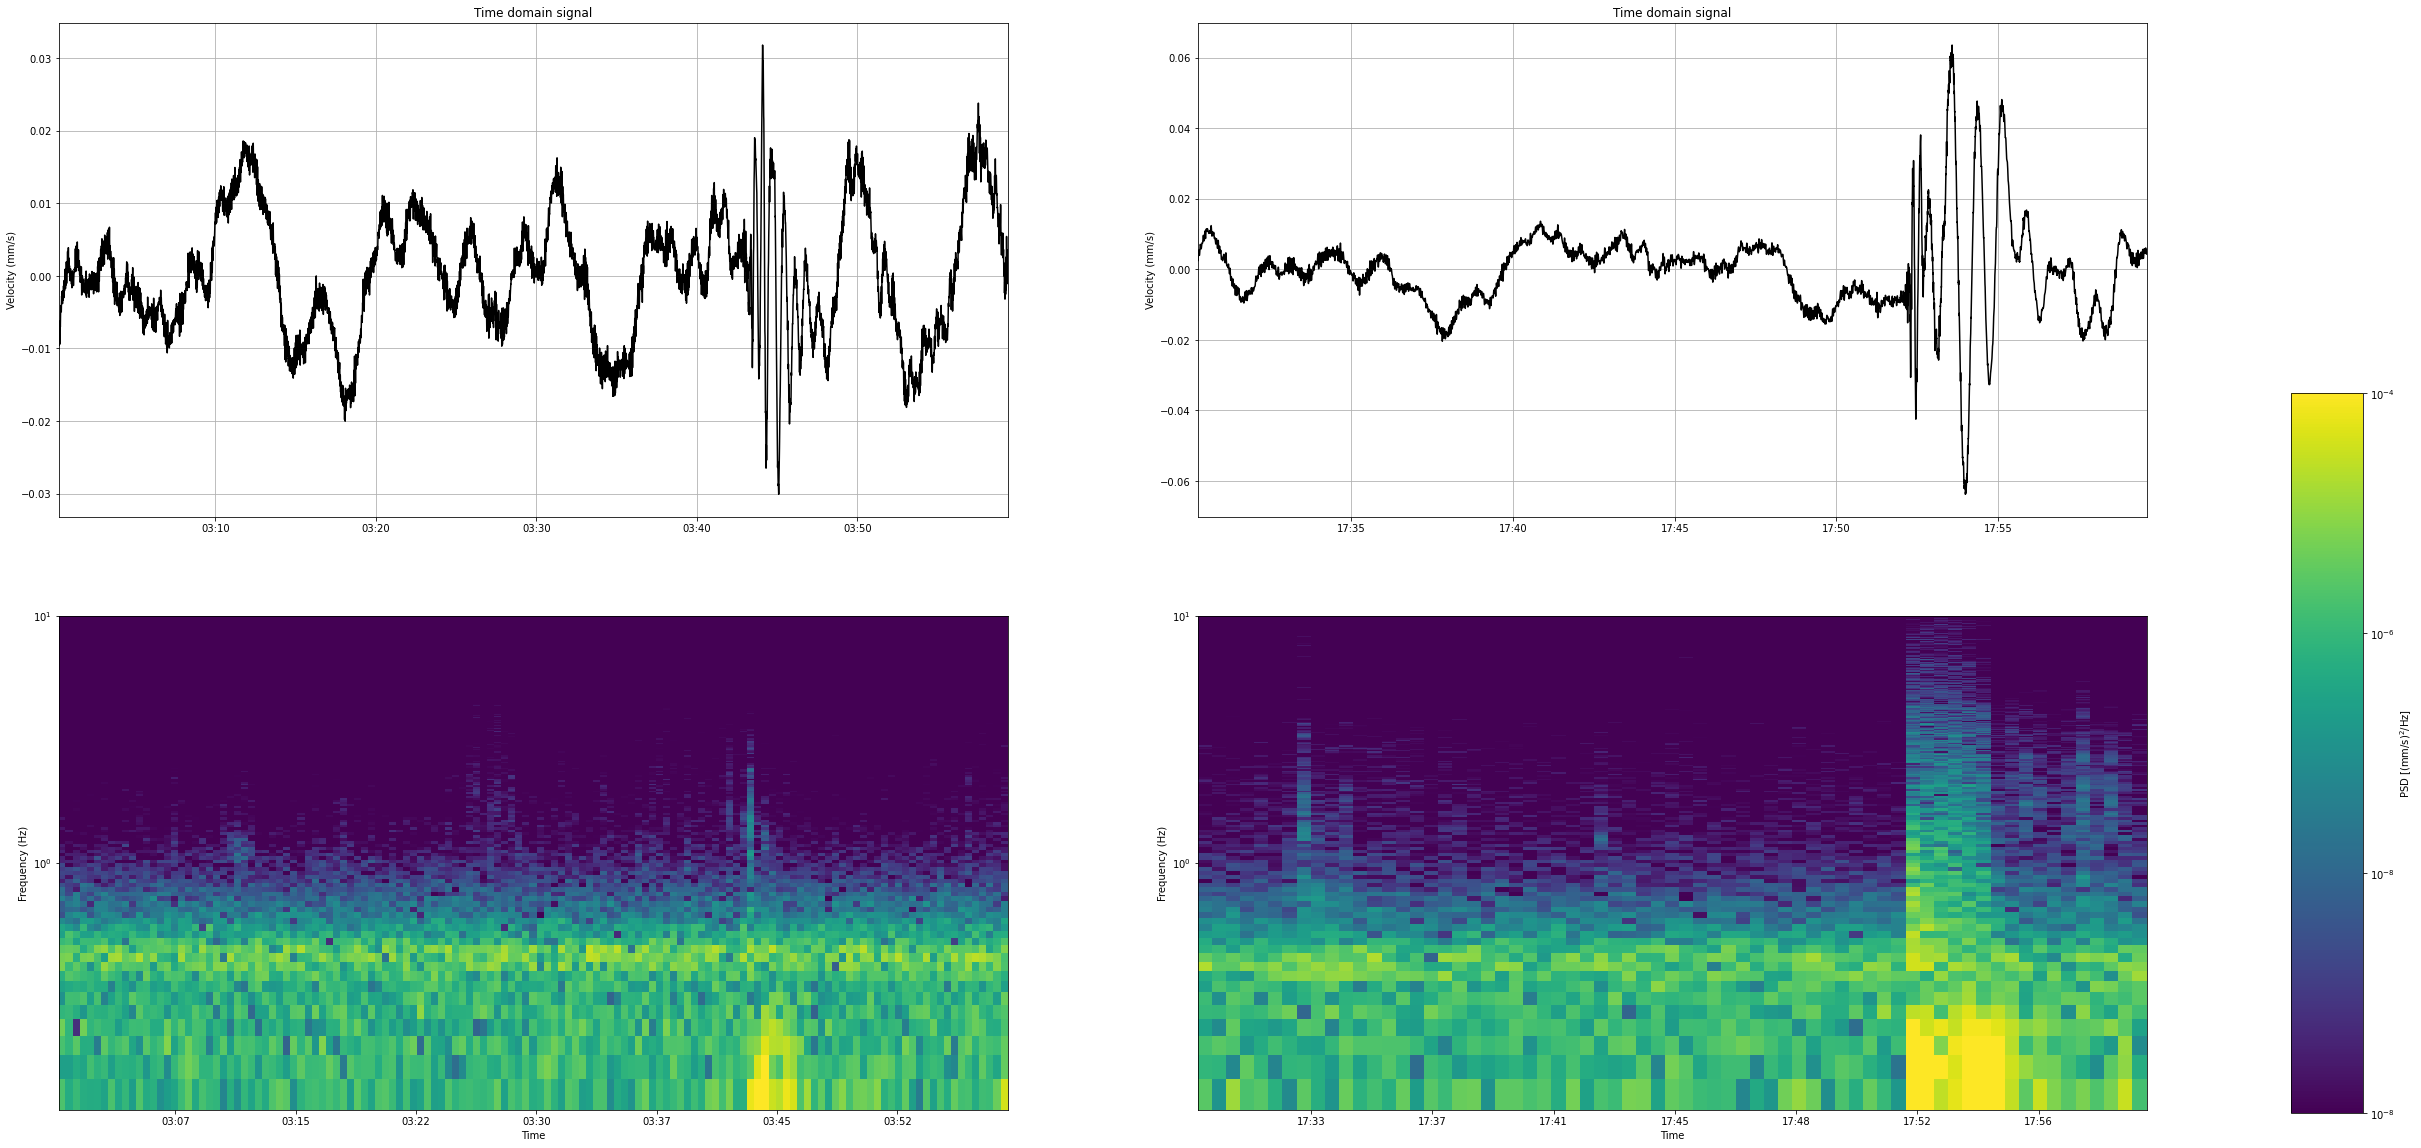

In [23]:
# zoom in on a low-frequency-first sounding event
#starttime = obspy.UTCDateTime(2012,5,9,10,50)
#endtime = obspy.UTCDateTime(2012,5,9,11,20)
starttime = obspy.UTCDateTime(2012,5,9,3)
endtime = obspy.UTCDateTime(2012,5,9,4)
swell_event = st_broad.copy().trim(starttime=starttime,endtime=endtime)

# zoom in on a high-frequency-first event
starttime = obspy.UTCDateTime(2012,5,9,17,30)
endtime = obspy.UTCDateTime(2012,5,9,18)
fg_event = st_broad.copy().trim(starttime=starttime,endtime=endtime)

# put data into a crude list
data = [swell_event,fg_event]

# make plot
fig,ax = plt.subplots(2,2,figsize=(40,20))

for i,st in enumerate(data):
    times = [t.datetime for t in st[0].times("UTCDateTime")]
    ticks = [times[len(times)//8],times[len(times)//4],times[len(times)//8*3],times[len(times)//2],times[len(times)//8*5],times[len(times)//4*3],times[len(times)//8*7],times[len(times)-1]]
    ax[0][i].plot(times,st[0].data*1000,'k')
    ax[0][i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[0][i].grid(True)
    ax[0][i].set_ylabel("Velocity (mm/s)")    
    ax[0][i].set_title("Time domain signal")

    # make spectrogram
    win_len = 30
    f,t,s = spectrogram(st[0].data*1000, fs=fs, nperseg=win_len*fs)

    # plot spectrogram 
    times = [st[0].stats.starttime.datetime + datetime.timedelta(seconds=time) for time in t]
    spec = ax[1][i].pcolor(times, np.log10(f), np.log10(s), vmin=np.log10(10e-11),vmax=np.log10(10e-5))
    ax[1][i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[1][i].get_shared_x_axes().join(ax[0][i],ax[1][i])
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xlim([times[0],times[-1]])
    ax[1][i].set_yticks([np.log10(low_cut),0,1])
    ax[1][i].set_ylim([-1,1])
    ax[1][i].set_yticklabels(["$10^{-1}$","$10^{0}$","$10^{1}$"])
    ax[1][i].set_ylabel("Frequency (Hz)")
    ax[1][i].set_xlabel("Time")
    plt.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.1225, 0.025, 0.5])
cbar = plt.colorbar(spec,label="PSD [(mm/s)$^2$/Hz]",ticks=[-10,-8,-6,-4],cax=cbar_ax)
cbar.ax.set_yticklabels(['$10^{-8}$','$10^{-8}$','$10^{-6}$','$10^{-4}$'])
plt.show()

In [ ]:
# get list of files
station = "PIG5"
files = glob.glob("/media/Data/Data/XC/MSEED/noIR/"+station+"/HHZ/*")
files.sort()

# make empty stream for storage
st = obspy.Stream()

# read in each file
for f in files:
    st_temp = obspy.read(f)
    
    # downsample data to 2.1 Hz
    st_temp.resample(2.1)
        
    # normalize to 1
    st_temp[0].data = st_temp[0].data/max(abs(st_temp[0].data)) 
        
    # add to stream 
    st += st_temp

# filter to band of interest
low_cut = 0.001
st.filter("bandpass", freqmin=low_cut, freqmax=1)

# merge stream
st.merge(fill_value='interpolate')

# write out audio file
st.write("../outputs/audio/"+station+"_HHZ_deployment.wav", format='WAV', framerate=700000, rescale=True, width=2)

In [19]:
# extract detection times for each event in the dataset
ds = pyasdf.ASDFDataSet("/home/setholinger/Documents/rift_codes/outputs/detections/template_matching_catalog.h5",mode='r')
detection_times = []
for event in ds.events:
    detection_times.append(event.origins[0].time.datetime)
del ds

# load event waveforms
waveform_file = h5py.File("/home/setholinger/Documents/rift_codes/outputs/stacking/waveforms_PIG2_0.01Hz.h5",'r')
waveforms = np.array(waveform_file['waveforms_0.01-1Hz'])
waveform_file.close()

# load clustering results
cluster_file = h5py.File("/home/setholinger/Documents/rift_codes/outputs/clustering/2_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

# load the results of polarization analysis
baz_file = open('/home/setholinger/Documents/rift_codes/outputs/locations/event_backazimuths_PIG1_PIG2_PIG3_PIG4_PIG5_distance_pca_fixed_centroid.pickle', "rb")
b = pickle.load(baz_file)
backazimuths = b.backazimuths
baz_file.close()

# subset the backazimuths for just dispersive events
backazimuths = backazimuths[predictions==0]

# subset detection times for just dispersive events
detection_times = np.array(detection_times)[predictions == 0]

# split into each spatial group
rift_tip_indices = np.logical_and(backazimuths>=180,backazimuths<280)
margin_indices = np.logical_and(backazimuths>=0,backazimuths<180)
rift_margin_indices = np.logical_and(backazimuths>=280,backazimuths<360) 

In [ ]:
# define function to pad with zeros to space events properly in time
def get_timeseries(detection_times,waveforms,fs,starttime,endtime):
    trace_len = waveforms.shape[1]
    first_gap = detection_times[0]-starttime
    first_gap_samples = int(np.round(first_gap.total_seconds()*fs))
    timeseries = np.zeros(first_gap_samples)
    gaps = np.diff(detection_times)
    for i in range(len(gaps)):
        gap_samples = int(np.round(gaps[i].total_seconds()*fs)-trace_len)
        if gap_samples < 0:
            timeseries = np.concatenate((timeseries,waveforms[i][:-(trace_len+gap_samples)]))
        else:
            timeseries = np.concatenate((timeseries,waveforms[i],np.zeros(gap_samples)))
    timeseries = np.concatenate((timeseries,waveforms[-1]))
    final_gap = endtime - detection_times[-1]
    final_gap_samples = int(np.round(final_gap.total_seconds()*fs)+trace_len)
    timeseries = np.concatenate((timeseries,np.zeros(final_gap_samples)))
    return timeseries

# pad with zeros so the events are appropriately spaced in time
fs = 2.1
starttime = datetime.datetime(2012,1,1,0,0)
endtime = datetime.datetime(2014,1,1,0,0)
rift_tip_timeseries = get_timeseries(detection_times[rift_tip_indices],waveforms[rift_tip_indices],fs,starttime,endtime)
margin_timeseries = get_timeseries(detection_times[margin_indices],waveforms[margin_indices],fs,starttime,endtime)
rift_margin_timeseries = get_timeseries(detection_times[rift_margin_indices],waveforms[rift_margin_indices],fs,starttime,endtime)

# define function to rescale each timeseries and write to an audio file
def write_wav(filename,data,sample_width,framerate):
    WIDTH2DTYPE = {1: '<u1', 2: '<i2',4: '<i4'}
    w = wave.open(filename, 'wb')
    w.setparams((1, sample_width, framerate, len(data), 'NONE','not compressed'))
    dtype = WIDTH2DTYPE[sample_width]
    data = data.astype(np.float64)
    maxint = 2 ** (sample_width * 8 - 1) - 1
    data = data / abs(data).max() * maxint
    data = np.require(data, dtype=dtype)
    w.writeframes(data.tobytes())
    return

# write each timeseries to audio file
sample_width = 4
framerate = 4.2e5
write_wav("../outputs/audio/rift_tip.wav",rift_tip_timeseries,sample_width,framerate)
write_wav("../outputs/audio/margin.wav",margin_timeseries,sample_width,framerate)
write_wav("../outputs/audio/rift_margin.wav",rift_margin_timeseries,sample_width,framerate)

In [20]:
# read in sonified file for each group of events
rift_audio = AudioSegment.from_file("../outputs/audio/rift_tip.wav")
margin_audio = AudioSegment.from_file("../outputs/audio/margin.wav")
rift_margin_audio = AudioSegment.from_file("../outputs/audio/rift_margin.wav")

# calculate median backazimuth for each group
rift_tip_backazimuth = np.median(backazimuths[rift_tip_indices])
margin_backazimuth = np.median(backazimuths[margin_indices])
rift_margin_backazimuth = np.median(backazimuths[rift_margin_indices])

# calculate the pan
ice_front_backazimuth = 300
rift_tip_pan = (rift_tip_backazimuth - ice_front_backazimuth)/90
margin_pan = (60 + margin_backazimuth)/90
rift_margin_pan = (rift_margin_backazimuth - ice_front_backazimuth)/90

# pan audio based on mean backazimuth, assuming the listener is facing from the array towards the ice front
rift_tip_panned = rift_audio.pan(rift_tip_pan)
margin_panned = margin_audio.pan(margin_pan)
rift_margin_panned = rift_margin_audio.pan(rift_margin_pan)

# increase volume of each track
db_increase = 7
rift_tip_panned += db_increase
margin_panned += db_increase
rift_margin_panned += db_increase

# combine audio files
stereo_icequakes = rift_margin_panned.overlay(rift_tip_panned.overlay(margin_panned))
file_handle = stereo_icequakes.export("../outputs/audio/stereo_icequakes.wav", format="wav")

In [ ]:
# naively try to shift frequencies for a cosine
fs = np.pi/16
wave = np.cos(np.arange(0,8*np.pi,np.pi/16))
t = np.arange(0,len(wave)*1/fs,1/fs)
wave_fft = fft(wave)
f = fftfreq(len(wave),fs)
wave_fft_pos = wave_fft[len(wave_fft)//2:]
wave_fft_neg = wave_fft[:len(wave_fft)//2]
wave_fft_shift_down = np.concatenate((wave_fft_neg,np.zeros(100),wave_fft_pos))
wave_ifft_shift_down = ifft(wave_fft_shift_down)
t_down = np.arange(0,len(wave_ifft_shift_down)*1/fs-1,1/fs)
wave_fft_shift_up = np.concatenate((wave_fft_neg[:-10],wave_fft_pos[10:]))
wave_ifft_shift_up = ifft(wave_fft_shift_up)
t_up = np.arange(0,len(wave_ifft_shift_up)*1/fs,1/fs)

# plot result
plt.figure(figsize=(20,10))
plt.plot(t,wave,label='Original signal')
plt.plot(t_down,wave_ifft_shift_down,label='Frequency shifted down')
plt.plot(t_up,wave_ifft_shift_up,label='Frequency shifted up')
plt.legend()
plt.show()

# try the naive method with real data
fs = 2.1
wave = margin_waveforms[1]
t = np.arange(0,len(wave)*1/fs,1/fs)
wave_fft = fft(wave)
f = fftfreq(len(wave),fs)
wave_fft_pos = wave_fft[len(wave_fft)//2:]
wave_fft_neg = wave_fft[:len(wave_fft)//2]
wave_fft_shift_up = np.concatenate((wave_fft_neg[:-500],wave_fft_pos[500:]))
f_up = fftfreq(len(wave_fft_shift_up),1/fs)
wave_ifft_shift_up = ifft(wave_fft_shift_up)
t_up = np.arange(0,len(wave_ifft_shift_up)*1/fs,1/fs)

# plot result- note that this is a bad way to shift frequencies up, because it destroys part of the spectra and causes signal degradation at large shifts
fig,ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(f[:len(f)//2+1],np.abs(wave_fft[:len(wave_fft)//2+1]),label='Original signal')
ax[0].plot(f_up[:len(f_up)//2+1],np.abs(wave_fft_shift_up[:len(wave_fft_shift_up)//2+1]),label='Frequency shifted up')
ax[0].legend()
ax[1].plot(t,wave,label='Original signal')
ax[1].plot(t_up,wave_ifft_shift_up,label='Frequency shifted up')
ax[1].legend()
plt.show()

# try a more intelligent method for a cosine
fs = 1/(np.pi/16)
wave = np.cos(np.arange(0,8*np.pi,np.pi/16))
t = np.arange(0,len(wave)*1/fs,1/fs)
wave_fft = fft(wave)
f = fftfreq(len(wave),fs)
wave_up = wave * np.cos(np.arange(0,8*np.pi,np.pi/16)*100)
wave_fft_shift_up = fft(wave_up)
f_up = fftfreq(len(wave_fft_shift_up),fs)
wave_fft_shift_up[np.logical_and(f_up > 0.01,f_up < 0.02)] = 0
wave_fft_shift_up[np.logical_and(f_up < -0.01,f_up > -0.02)] = 0
wave_ifft_shift_up = ifft(wave_fft_shift_up)
t_up = np.arange(0,len(wave_ifft_shift_up)*1/fs,1/fs)

# plot result- note that we quickly run up against the nyquist frequency, so this isn't a good method either...
fig,ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(f[:len(f)//2],np.abs(wave_fft[:len(wave_fft)//2]),label='Original signal')
ax[0].plot(f_up[:len(f)//2],np.abs(wave_fft_shift_up[:len(wave_fft_shift_up)//2]),label='Frequency shifted up')
ax[0].legend()
ax[1].plot(t,wave,label='Original signal')
ax[1].plot(t_up,wave_ifft_shift_up,label='Frequency shifted up')
ax[1].legend()
plt.show()